## Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras import models,metrics,layers,optimizers
from tensorflow.keras.layers import Input, Dense, Lambda,Layer,Concatenate,BatchNormalization,Activation,LeakyReLU,Dropout
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow import keras
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Conv2D, Flatten, Reshape, Conv2DTranspose
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay


## Basic VAE on MNIST

In [32]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255. 

x_train = x_train.reshape((x_train.shape[0], -1))
x_test = x_test.reshape((x_test.shape[0], -1))

num_classes = 10
y_train_one_hot = to_categorical(y_train, num_classes)
y_test_one_hot = to_categorical(y_test, num_classes)


In [44]:
class Sampling(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

latent_dim = 2
num_classes = 10  

encoder_inputs = Input(shape=(784,))
class_inputs = Input(shape=(num_classes,))
x = Concatenate()([encoder_inputs, class_inputs])
x = Dense(256, activation='relu')(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model([encoder_inputs, class_inputs], [z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = Input(shape=(latent_dim,))
decoder_class_inputs = Input(shape=(num_classes,))
x = Concatenate()([latent_inputs, decoder_class_inputs])
x = Dense(256, activation='relu')(x)
decoder_outputs = Dense(784, activation='sigmoid')(x)
decoder = Model([latent_inputs, decoder_class_inputs], decoder_outputs, name="decoder")

# VAE Model
vae_outputs = decoder([encoder([encoder_inputs, class_inputs])[2], class_inputs])
vae = Model(inputs=[encoder_inputs, class_inputs], outputs=vae_outputs, name="vae")

def vae_loss(encoder_inputs, vae_outputs, z_mean, z_log_var):
    reconstruction_loss = binary_crossentropy(encoder_inputs, vae_outputs) * 784
    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    return tf.reduce_mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss(encoder_inputs, vae_outputs, z_mean, z_log_var))
vae.compile(optimizer='adam')


vae.fit([x_train, y_train_one_hot], x_train, epochs=30, batch_size=128, validation_data=([x_test, y_test_one_hot], x_test))

Epoch 1/30
469/469 [==============================] - 3s 4ms/step - loss: 187.0646 - val_loss: 151.7664
Epoch 2/30
469/469 [==============================] - 2s 5ms/step - loss: 147.0262 - val_loss: 143.5470
Epoch 3/30
469/469 [==============================] - 2s 4ms/step - loss: 142.3480 - val_loss: 140.9505
Epoch 4/30
469/469 [==============================] - 2s 5ms/step - loss: 140.2202 - val_loss: 139.1636
Epoch 5/30
469/469 [==============================] - 2s 5ms/step - loss: 138.8308 - val_loss: 138.0882
Epoch 6/30
469/469 [==============================] - 2s 5ms/step - loss: 137.7728 - val_loss: 137.3168
Epoch 7/30
469/469 [==============================] - 2s 4ms/step - loss: 136.9441 - val_loss: 136.6901
Epoch 8/30
469/469 [==============================] - 2s 5ms/step - loss: 136.2263 - val_loss: 136.0189
Epoch 9/30
469/469 [==============================] - 2s 5ms/step - loss: 135.6188 - val_loss: 135.4254
Epoch 10/30
469/469 [==============================] - 2s 5ms/st

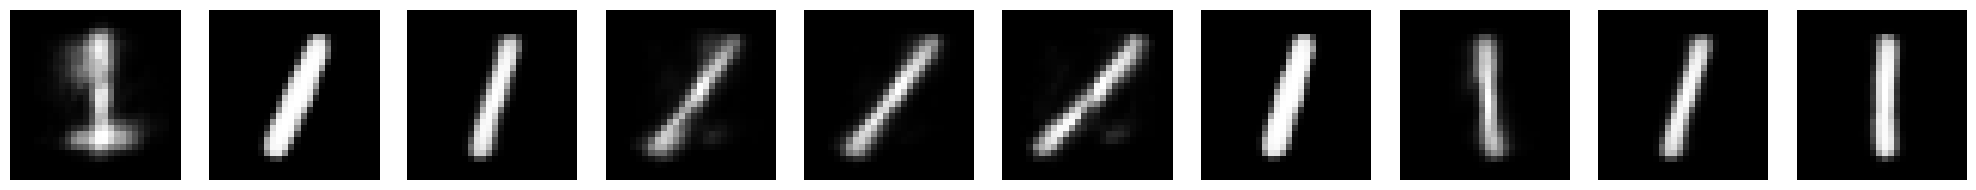

In [46]:
def generate_samples(decoder, digit, num_samples=10):

    z_sample = np.random.normal(size=(num_samples, latent_dim))
    
    digit_one_hot = np.zeros((num_samples, num_classes))
    digit_one_hot[:, digit] = 1
    
    generated_images = decoder.predict([z_sample, digit_one_hot])
    
    generated_images = generated_images.reshape(num_samples, 28, 28)
    
    return generated_images

digit_to_generate = 1
samples = generate_samples(decoder, digit_to_generate, 10)

fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for img, ax in zip(samples, axes):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()


## Condition VAE Approach

In [2]:
base_dir = 'D:\\Projects\\GenAI\\Dataset\\VOCdevkit\\VOC2008'
images_dir = os.path.join(base_dir, 'JPEGImages')
labels_dir = os.path.join(base_dir, 'ImageSets', 'Main')

classes = ['aeroplane', 'bicycle','bird','boat','bottle','bus','car','cat','chair','cow','diningtable','dog','horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor'] 

image_labels = {cls: {} for cls in classes}

for cls in classes:
    label_file = os.path.join(labels_dir, f'{cls}_train.txt')
    with open(label_file, 'r') as file:
        for line in file:
            image_name, label = line.strip().split()
            label = int(label)
            image_labels[cls][image_name] = label

def load_images_and_labels(image_labels, classes, images_dir, target_size=(224, 224)):
    images = []
    labels = []

    for cls, labels_map in image_labels.items():
        for image_name, label in labels_map.items():
            if label == 1: 
                image_path = os.path.join(images_dir, f'{image_name}.jpg')
                image = load_img(image_path, target_size=target_size)
                image = img_to_array(image)
                images.append(image)
               
                label_vector = [1 if cls == c else 0 for c in classes]
                labels.append(label_vector)

    return np.array(images), np.array(labels)

images, labels = load_images_and_labels(image_labels, classes, images_dir)

print(f'Loaded {len(images)} images')
print(f'Image shape: {images[0].shape}')
print(f'First image labels: {labels[0]}')
images.shape,labels.shape

Loaded 3036 images
Image shape: (224, 224, 3)
First image labels: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


((3036, 224, 224, 3), (3036, 20))

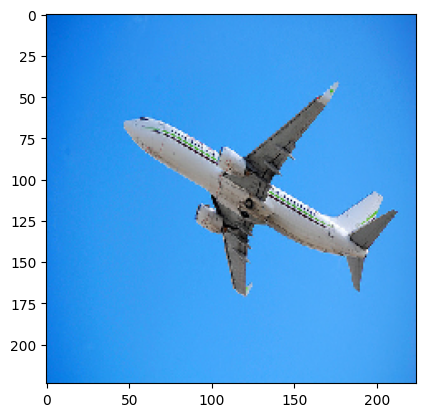

In [3]:
plt.imshow(images[0].astype('uint8'))

In [8]:
num_classes= 20
labels_one_hot = tf.keras.utils.to_categorical(labels, num_classes=num_classes)

In [12]:
def preprocess(img, label):
    return (img, label), img

train_dataset = tf.data.Dataset.from_tensor_slices((images, labels))
train_dataset = train_dataset.map(preprocess)
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(16)


In [20]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        epsilon_value = 1e-7  # Epsilon for numerical stability
        return z_mean + tf.exp(0.5 * z_log_var + epsilon_value) * epsilon


latent_dim = 2

# Encoder
encoder_inputs = Input(shape=(224, 224, 3), name='encoder_input')
class_inputs = Input(shape=(num_classes,), name='class_input')
x = Conv2D(32, 3, padding='same')(encoder_inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(64, 3, padding='same', strides=2)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Conv2D(128, 3, padding='same', strides=2)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
shape_before_flattening = tf.keras.backend.int_shape(x)
x = Flatten()(x)
x = Concatenate()([x, class_inputs])
x = Dense(256, activation='relu')(x)
z_mean = Dense(latent_dim)(x)
z_log_var = Dense(latent_dim)(x)
z = Sampling()([z_mean, z_log_var])
encoder = Model([encoder_inputs, class_inputs], [z_mean, z_log_var, z], name="encoder")


# Decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
class_inputs_decoder = Input(shape=(num_classes,), name='class_labels')
decoder_inputs = Concatenate()([latent_inputs, class_inputs_decoder])
x = Dense(np.prod(shape_before_flattening[1:]), activation='relu')(decoder_inputs)
x = Reshape(shape_before_flattening[1:])(x)
x = Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = BatchNormalization()(x)
x = Conv2DTranspose(32, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
decoder_outputs = Conv2DTranspose(3, 3, activation='sigmoid', padding='same')(x)
decoder = Model([latent_inputs, class_inputs_decoder], decoder_outputs, name="decoder")


# VAE Model
vae_outputs = decoder([encoder([encoder_inputs, class_inputs])[2], class_inputs])
vae = Model(inputs=[encoder_inputs, class_inputs], outputs=vae_outputs, name="vae")

def vae_loss_function(encoder_inputs, vae_outputs, z_mean, z_log_var):
    reconstruction_loss = binary_crossentropy(tf.keras.backend.flatten(encoder_inputs),
                                              tf.keras.backend.flatten(vae_outputs)) * 224 * 224 * 3
    kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
    return tf.reduce_mean(reconstruction_loss + kl_loss)

vae.add_loss(vae_loss_function(encoder_inputs, vae_outputs, z_mean, z_log_var))
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4,clipvalue=0.3)

checkpoint_filepath = "model.{epoch:02d}-{loss:.2f}.h5"

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',  
    mode='min',
    save_best_only=True)

callbacks = [model_checkpoint_callback]


vae.compile(optimizer=optimizer)



In [21]:
vae.fit(train_dataset, epochs=80,callbacks=callbacks)

Epoch 1/80
190/190 [==============================] - 37s 183ms/step - loss: -5524735.5000
Epoch 2/80
190/190 [==============================] - 35s 184ms/step - loss: -56624796.0000
Epoch 3/80
190/190 [==============================] - 35s 185ms/step - loss: 22330554187776.0000
Epoch 4/80
190/190 [==============================] - 34s 181ms/step - loss: 773753270500851712.0000
Epoch 5/80
190/190 [==============================] - 35s 184ms/step - loss: 615128128.0000
Epoch 6/80
190/190 [==============================] - 35s 184ms/step - loss: 42524192768.0000
Epoch 7/80
190/190 [==============================] - 34s 181ms/step - loss: 5821738147213475840.0000
Epoch 8/80
190/190 [==============================] - 36s 188ms/step - loss: 3210591818885641778757632.0000
Epoch 9/80
190/190 [==============================] - 36s 191ms/step - loss: 12019868714671603187712.0000
Epoch 10/80
190/190 [==============================] - 35s 186ms/step - loss: 13127665276912104636416.0000
Epoch 11/8

KeyboardInterrupt: 

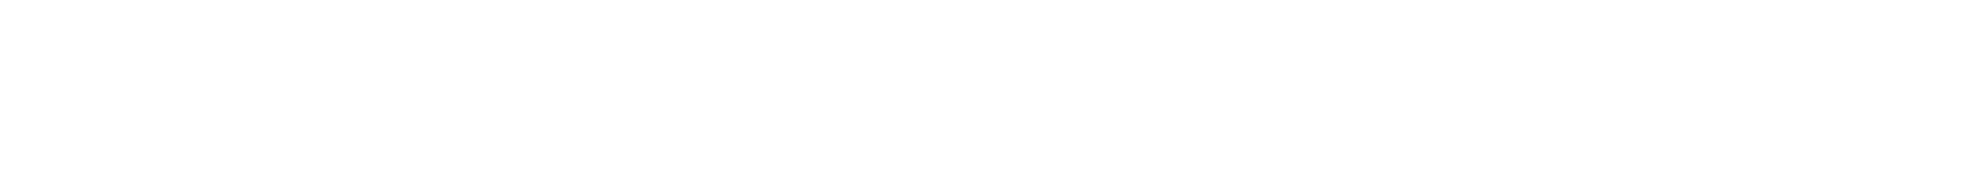

In [23]:
def generate_conditional_images(decoder, num_samples, class_index, num_classes):

    z_sample = np.random.normal(size=(num_samples, latent_dim))
    
    class_vector = np.zeros((num_samples, num_classes))
    class_vector[:, class_index] = 1
    
    generated_images = decoder.predict([z_sample, class_vector])
    
    return generated_images

num_classes = 20 
desired_class_index = 1 

generated_images = generate_conditional_images(decoder, 10, desired_class_index, num_classes)


fig, axes = plt.subplots(1, 10, figsize=(20, 2))
for img, ax in zip(generated_images, axes):
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()


results are not good hence using individual vae for each class

## Individual VAE Approach

### Version 1

In [3]:
base_dir = 'D:\\Projects\\GenAI\\Dataset\\VOCdevkit\\VOC2008'
images_dir = os.path.join(base_dir, 'JPEGImages')
labels_dir = os.path.join(base_dir, 'ImageSets', 'Main')

classes = ['aeroplane', 'bicycle','bird','boat','bottle','bus','car','cat','chair','cow','diningtable','dog','horse','motorbike','person','pottedplant','sheep','sofa','train','tvmonitor'] 

image_labels = {cls: {} for cls in classes}

for cls in classes:
    label_file = os.path.join(labels_dir, f'{cls}_train.txt')
    with open(label_file, 'r') as file:
        for line in file:
            image_name, label = line.strip().split()
            label = int(label)
            image_labels[cls][image_name] = label

def load_images_and_labels(image_labels, classes, images_dir, target_size=(224, 224)):
    images = []
    labels = []

    for cls, labels_map in image_labels.items():
        for image_name, label in labels_map.items():
            if label == 1: # Only load images where the class is present
                image_path = os.path.join(images_dir, f'{image_name}.jpg')
                image = load_img(image_path, target_size=target_size)
                image = img_to_array(image)
                images.append(image)
                # Create a one-hot encoded label vector
                label_vector = [1 if cls == c else 0 for c in classes]
                labels.append(label_vector)

    return np.array(images), np.array(labels)

images, labels = load_images_and_labels(image_labels, classes, images_dir)

print(f'Loaded {len(images)} images')
print(f'Image shape: {images[0].shape}')
print(f'First image labels: {labels[0]}')
images.shape,labels.shape

Loaded 3036 images
Image shape: (224, 224, 3)
First image labels: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


((3036, 224, 224, 3), (3036, 20))

In [243]:
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape, Conv2D, Conv2DTranspose, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K



In [244]:
class_index = 0  
class_labels = labels[:, class_index]
class_images = images[class_labels == 1]
#class_images = class_images.astype('float32') / 255.

In [245]:
epochs = 3500
batch_size = 32
latent_dim = 2

en,dec,model = train_vae_for_class(class_images,epochs,batch_size,latent_dim)

Epoch 1/3500
4/4 [==============================] - 1s 93ms/step - loss: 104321.7109
Epoch 2/3500
4/4 [==============================] - 0s 92ms/step - loss: 104233.0078
Epoch 3/3500
4/4 [==============================] - 0s 91ms/step - loss: 106954.5312
Epoch 4/3500
4/4 [==============================] - 0s 91ms/step - loss: 103125.7656
Epoch 5/3500
4/4 [==============================] - 0s 91ms/step - loss: 103988.3281
Epoch 6/3500
4/4 [==============================] - 0s 91ms/step - loss: 104049.7578
Epoch 7/3500
4/4 [==============================] - 0s 92ms/step - loss: 104040.7266
Epoch 8/3500
4/4 [==============================] - 0s 91ms/step - loss: 104024.2344
Epoch 9/3500
4/4 [==============================] - 0s 93ms/step - loss: 103874.5000
Epoch 10/3500
4/4 [==============================] - 0s 91ms/step - loss: 103421.3906
Epoch 11/3500
4/4 [==============================] - 0s 91ms/step - loss: 102879.5234
Epoch 12/3500
4/4 [==============================] - 0s 92ms/st

KeyboardInterrupt: 

In [197]:
# def generate_images(decoder, num_images=10, latent_dim=50):
#     z_sample = np.random.normal(size=(num_images, latent_dim))
#     generated_images = decoder.predict(z_sample)
#     # Post-process the images (e.g., rescaling pixel values)
#     generated_images = np.clip(generated_images, 0, 1)
#     return generated_images


In [233]:
def generate_and_plot_images(decoder, num_images=10, latent_dim=2):
    # Generate random points in the latent space
    z_sample = np.random.normal(size=(num_images, latent_dim))
    # Generate images from the latent space samples
    generated_images = decoder.predict(z_sample)

    # Convert the images from normalized [0, 1] range back to [0, 255]
    #generated_images = np.clip(generated_images * 255, 0, 255).astype('uint8')

    # Plotting
    return generated_images



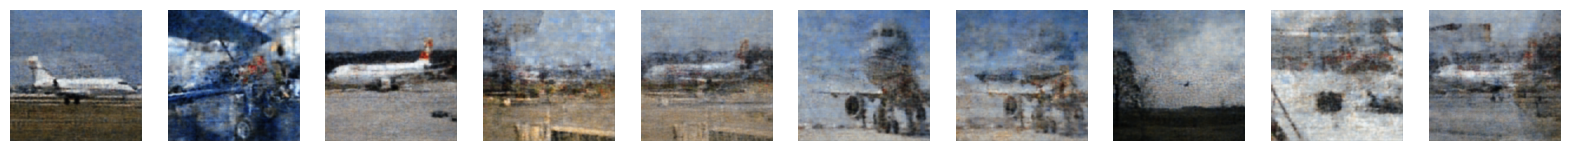

In [228]:
generate_images(dec,10,latent_dim)

 Doing this for every class

In [229]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']
base_dir = 'D:\\Projects\\GenAI\\Dataset\\VOCdevkit\\VOC2008'
images_dir = os.path.join(base_dir, 'JPEGImages')
labels_dir = os.path.join(base_dir, 'ImageSets', 'Main')

image_labels = {cls: {} for cls in classes}
for cls in classes:
    label_file = os.path.join(labels_dir, f'{cls}_train.txt')
    with open(label_file, 'r') as file:
        for line in file:
            image_name, label = line.strip().split()
            label = int(label)
            if label == 1:  
                image_labels[cls][image_name] = label

images, labels = load_images_and_labels(image_labels, classes, images_dir)


In [248]:
epochs = 4000
batch_size = 32
latent_dim = 2
num_generated_images = 100  

models_dir = 'D:\\Projects\\GenAI\\Extra\\Emaan Vae\\models'

os.makedirs(models_dir, exist_ok=True)

In [249]:
for class_index, cls in enumerate(classes):
    print(f'Training VAE for class: {cls}')
    class_labels = labels[:, class_index]
    class_images = images[class_labels == 1]
    
    encoder, decoder, vae = train_vae_for_class(class_images, epochs, batch_size, latent_dim)
    
    # Generate images
    generated_images = generate_and_plot_images(decoder, num_images=num_generated_images, latent_dim=latent_dim)
    
    class_dir = os.path.join(models_dir, cls)
    os.makedirs(class_dir, exist_ok=True)
    
    for i, img in enumerate(generated_images):
        plt.imsave(os.path.join(class_dir, f'generated_{i}.png'), img)
    
    vae.save(os.path.join(models_dir, f'{cls}_vae.h5'))
    encoder.save(os.path.join(models_dir, f'{cls}_encoder.h5'))
    decoder.save(os.path.join(models_dir, f'{cls}_decoder.h5'))

    print(f'Completed training and generation for class: {cls}')

Training VAE for class: aeroplane
Epoch 1/4000
4/4 [==============================] - 1s 94ms/step - loss: 104309.2422
Epoch 2/4000
4/4 [==============================] - 0s 92ms/step - loss: 103930.0000
Epoch 3/4000
4/4 [==============================] - 0s 91ms/step - loss: 103331.6406
Epoch 4/4000
4/4 [==============================] - 0s 91ms/step - loss: 103199.3906
Epoch 5/4000
4/4 [==============================] - 0s 91ms/step - loss: 102353.5781
Epoch 6/4000
4/4 [==============================] - 0s 92ms/step - loss: 101986.0938
Epoch 7/4000
4/4 [==============================] - 0s 91ms/step - loss: 101208.8047
Epoch 8/4000
4/4 [==============================] - 0s 91ms/step - loss: 100722.0312
Epoch 9/4000
4/4 [==============================] - 0s 92ms/step - loss: 99803.2656
Epoch 10/4000
4/4 [==============================] - 0s 91ms/step - loss: 99751.6562
Epoch 11/4000
4/4 [==============================] - 0s 91ms/step - loss: 99319.3281
Epoch 12/4000
4/4 [=============

In [251]:
## Generating more Images using saved decoder

In [257]:
def load_decoder_for_class(cls, models_dir='D:\\Projects\\GenAI\\Extra\\Emaan Vae\\models'):

    decoder_path = os.path.join(models_dir, f'{cls}_decoder.h5')
    decoder = load_model(decoder_path)
    return decoder


In [258]:
def generate_and_save_images(decoder, num_images, latent_dim, save_dir):

    z_sample = np.random.normal(size=(num_images, latent_dim))
    generated_images = decoder.predict(z_sample)

    for i, img in enumerate(generated_images):
        img_path = os.path.join(save_dir, f'additional_generated_{i}.png')
        plt.imsave(img_path, img)


In [259]:
num_additional_images = 100  

for cls in classes:
    print(f'Generating additional images for class: {cls}')
    decoder = load_decoder_for_class(cls, models_dir)
    
    class_dir = os.path.join(models_dir, cls)
    
    os.makedirs(class_dir, exist_ok=True)
    
    generate_and_save_images(decoder, num_additional_images, latent_dim, class_dir)
    
    print(f'Completed generating additional images for class: {cls}')


Generating additional images for class: aeroplane
Completed generating additional images for class: aeroplane
Generating additional images for class: bicycle
Completed generating additional images for class: bicycle
Generating additional images for class: bird
Completed generating additional images for class: bird
Generating additional images for class: boat
Completed generating additional images for class: boat
Generating additional images for class: bottle
Completed generating additional images for class: bottle
Generating additional images for class: bus
Completed generating additional images for class: bus
Generating additional images for class: car
Completed generating additional images for class: car
Generating additional images for class: cat
Completed generating additional images for class: cat
Generating additional images for class: chair
Completed generating additional images for class: chair
Generating additional images for class: cow
Completed generating additional images f

In [261]:
class_dir

'D:\\Projects\\GenAI\\Extra\\Emaan Vae\\models\\tvmonitor'

### Version 2

In [212]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)


In [215]:



def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian."""
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)


def build_vae(input_shape, latent_dim=2):
    # Encoder
    inputs = Input(shape=input_shape, name='encoder_input')
    x = Conv2D(32, 3, activation='relu', strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    x = Conv2D(64, 3, activation='relu', strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    x = Conv2D(128, 3, activation='relu', strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    x = Conv2D(256, 3, activation='relu', strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    volume_size = K.int_shape(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)

    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
    
    # Decoder
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
    x = Dense(volume_size[1] * volume_size[2] * volume_size[3], activation='relu')(latent_inputs)
    x = Reshape((volume_size[1], volume_size[2], volume_size[3]))(x)
    x = Conv2DTranspose(256, 3, activation='relu', strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    x = Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    x = Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    x = Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)
    outputs = Conv2DTranspose(3, 3, activation='sigmoid', padding='same', name='decoder_output')(x)

    decoder = Model(latent_inputs, outputs, name='decoder')
    
    # VAE model
    outputs = decoder(encoder(inputs)[2])
    vae = Model(inputs, outputs, name='vae')
    
    # Loss function
    reconstruction_loss = binary_crossentropy(K.flatten(inputs), K.flatten(outputs)) * K.prod(K.cast(K.shape(inputs)[1:], 'float32'))
    kl_loss = -0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss)
    
    vae.compile(optimizer=Adam(learning_rate=lr_schedule))

    return encoder, decoder, vae


In [ ]:
class_index = 0 
class_labels = labels[:, class_index]
class_images = images[class_labels == 1]
#class_images = class_images.astype('float32') / 255.

In [217]:
epochs = 500
batch_size = 32
latent_dim = 2

en,dec,model = train_vae_for_class(class_images,epochs,batch_size,latent_dim)

Epoch 1/500
4/4 [==============================] - 2s 136ms/step - loss: 135668.0938
Epoch 2/500
4/4 [==============================] - 1s 135ms/step - loss: 128680.0000
Epoch 3/500
4/4 [==============================] - 1s 134ms/step - loss: 115460.7500
Epoch 4/500
4/4 [==============================] - 1s 129ms/step - loss: 110443.4844
Epoch 5/500
4/4 [==============================] - 1s 131ms/step - loss: 108804.9219
Epoch 6/500
4/4 [==============================] - 1s 131ms/step - loss: 107919.5312
Epoch 7/500
4/4 [==============================] - 1s 131ms/step - loss: 107044.2422
Epoch 8/500
4/4 [==============================] - 1s 131ms/step - loss: 107316.5312
Epoch 9/500
4/4 [==============================] - 1s 131ms/step - loss: 106769.0625
Epoch 10/500
4/4 [==============================] - 1s 135ms/step - loss: 105843.9922
Epoch 11/500
4/4 [==============================] - 1s 132ms/step - loss: 105128.2891
Epoch 12/500
4/4 [==============================] - 1s 129ms/st

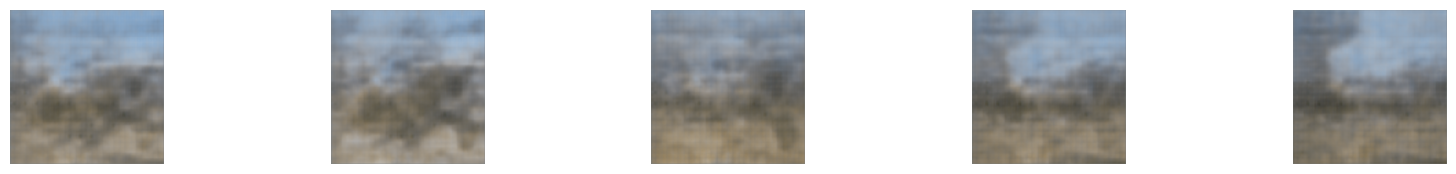

In [223]:
generate_images(dec,5,latent_dim)

Not good results